<center>
<p style="text-align: center;"><b><i>Pneumonia Detection Using Convolutional Neural Networks (CNN)</i></b></p>
Prepared by Abir LASSOUED

</center>

<p align="center">
  <img src="https://image.gezondheid.be/xtra/AI_pneumonie_longontsteking_2023.jpg"
alt="Titanic Dataset" width="800"/>
</p>

# Dataset Overview

Pneumonia is an infection that inflames the air sacs in one or both lungs. It kills more children younger than 5 years old each year than any other infectious disease, such as HIV infection, malaria, or tuberculosis. Diagnosis is often based on symptoms and physical examination. Chest X-rays may help confirm the diagnosis.

# Importing the necessary libraries

In [8]:
!pip install kaggle

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 #partie d'OpenCV, pour lire et manipuler des images.
import os
import json
from zipfile import ZipFile

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

#Loading the Dataset

In [12]:
kaggle_dictionary = json.load(open("kaggle.json"))

In [13]:
kaggle_dictionary.keys()

dict_keys(['username', 'key'])

In [14]:
# setup kaggle credentials as environment variables
os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]

In [15]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
 99% 1.17G/1.17G [00:17<00:00, 76.4MB/s]
100% 1.17G/1.17G [00:18<00:00, 69.8MB/s]


In [16]:
!ls

kaggle.json  labeled-chest-xray-images.zip  sample_data


In [17]:
# unzip the dataset file
with ZipFile("labeled-chest-xray-images.zip", "r") as zip_ref:
  zip_ref.extractall()

In [18]:
!ls

chest_xray  kaggle.json  labeled-chest-xray-images.zip	sample_data


In [19]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    X = []
    y = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(e)
    return (np.array(X),np.array(y))

In [20]:
X_train, y_train = get_data('/content/chest_xray/train')
X_test, y_test = get_data('/content/chest_xray/test')

In [21]:
print('la dimension de X_train est : ', X_train.shape)
print('la dimension de y_train est : ',y_train.shape)
print('la dimension de X_test est : ',X_test.shape)
print('la dimension de y_test est : ',y_test.shape)

la dimension de X_train est :  (5232, 150, 150)
la dimension de y_train est :  (5232,)
la dimension de X_test est :  (624, 150, 150)
la dimension de y_test est :  (624,)


# Visualisation

Text(0.5, 1.0, 'NORMAL')

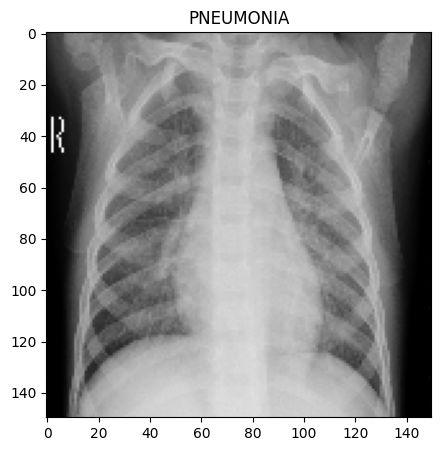

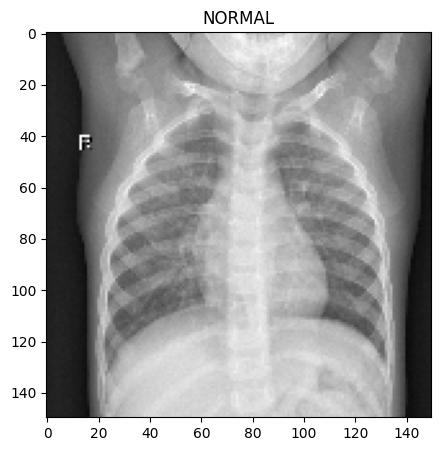

In [22]:
plt.figure(figsize = (5,5))
plt.imshow(X_train[0], cmap='gray')
plt.title(labels[y_train[0]])

plt.figure(figsize = (5,5))
plt.imshow(X_train[-1], cmap='gray')
plt.title(labels[y_train[-1]])

(array([0, 1]), array([3883, 1349]))

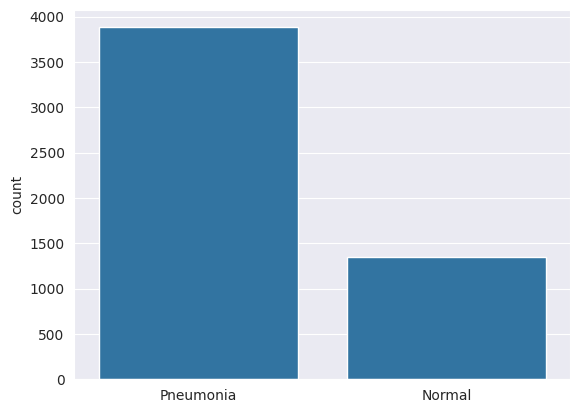

In [23]:
l = []
for i in y_train:
    if i == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)
np.unique(y_train, return_counts=True)

# Augmentation des données

Augmenter artificiellement le nombre d'images dans l'ensemble d'entraînement pour rendre le modèle plus robuste.

Faire pivoter, translater, zoomer et inverser horizontalement les images pour générer de nouvelles images à partir de celles existantes.

In [24]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

Les images augmentées ne sont ajoutées que pour la classe minoritaire (NORMAL) pour équilibrer les données, réduisant ainsi le biais vers la classe majoritaire (PNEUMONIA).

In [25]:
# Remarque : Nous n'augmentons que les images de la classe
class_1_indices = np.where(y_train == 1)[0]
class_1_images = X_train[class_1_indices]

In [26]:
augmented_images = []
class_1_images = np.expand_dims(class_1_images, axis=-1)

for batch in datagen.flow(class_1_images, batch_size=len(class_1_images), shuffle=False):
    augmented_images.extend(batch)
    break
augmented_images = np.squeeze(augmented_images, axis=-1)

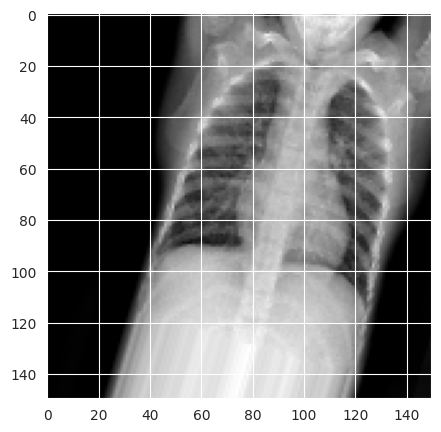

In [27]:
plt.figure(figsize = (5,5))
plt.imshow(augmented_images[0], cmap='gray')

In [28]:
# Ajouter les images augmentées à l'ensemble d'entraînement
augmented_labels = np.ones(len(augmented_images))
X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, augmented_labels))

In [29]:
# Diviser les données d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [30]:
# Convertir les données en format approprié pour Keras
# Convertir les données en float32 et normaliser les pixels entre 0 et 1
x_train = X_train.astype('float32') / 255.
x_val = X_val.astype('float32') / 255.
x_test = X_test.astype('float32')/ 255

In [31]:
# Redimensionner les données pour l'apprentissage profond.
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

In [32]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(x_train)

L'augmentation de données est une technique qui permet d'élargir votre ensemble de données d'entraînement en générant des images modifiées à partir des images originales. Cela peut aider à améliorer la performance du modèle en le rendant plus robuste et en évitant le surapprentissage (overfitting).

# Entraînement du modèle

In [33]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' ,
                 activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 38, 38, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 38, 38, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46208)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,914,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │              

 Total params: 6,193,729 (23.63 MB)

 Trainable params: 6,192,897 (23.62 MB)

 Non-trainable params: 832 (3.25 KB)

In [34]:
# ajuster dynamiquement le taux d’apprentissage pendant l’entraînement en fonction des performances du modèle sur un ensemble de validation.
# Cela peut conduire à une meilleure convergence et performance du modèle.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.00001
)

In [35]:
# Ajoutez un early stopping pour éviter le overfitting et économiser du temps d’entraînement.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [36]:
# Enregistrer le meilleur modèle pendant la formation en fonction des performances de validation
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [37]:
# apprentissage du modèle
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learning_rate_reduction, early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7017 - loss: 4.8086 
Epoch 1: val_loss improved from inf to 15.35058, saving model to best_model.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 1831s 11s/step - accuracy: 0.7022 - loss: 4.7890 - val_accuracy: 0.5869 - val_loss: 15.3506 - learning_rate: 0.0010
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8379 - loss: 0.4002 
Epoch 2: val_loss improved from 15.35058 to 3.18006, saving model to best_model.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 1893s 11s/step - accuracy: 0.8380 - loss: 0.4001 - val_accuracy: 0.5869 - val_loss: 3.1801 - learning_rate: 0.0010
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8701 - loss: 0.3518 
Epoch 3: val_loss did not improve from 3.18006
165/165 ━━━━━━━━━━━━━━━━━━━━ 1815s 11s/step - accuracy: 0.8702 - loss: 0.3517 - val_accuracy: 0.5869 - val_loss: 3.2751 - learning_rate: 0.0010
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8788 - loss: 0.3010
Epoch 4: val_los

In [38]:
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f'Final Training Loss: {train_loss}')
print(f'Final Validation Loss: {val_loss}')
print(f'Final Training Accuracy: {train_accuracy}')
print(f'Final Validation Accuracy: {val_accuracy}')

Final Training Loss: 0.10446235537528992
Final Validation Loss: 0.25429436564445496
Final Training Accuracy: 0.9637157917022705
Final Validation Accuracy: 0.8952164053916931


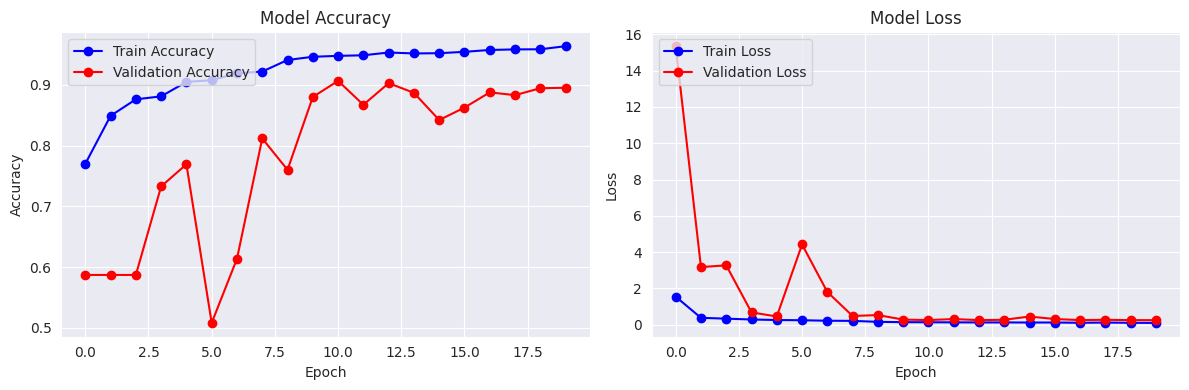

In [39]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Train Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
evalu = model.evaluate(x_test, y_test)
print("Loss du modèle est : " , evalu[0])
print("Accuracy du modèle est : ", evalu[1]*100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9203 - loss: 0.1769
Loss du modèle est :  0.2455374151468277
Accuracy du modèle est :  89.42307829856873 %


In [41]:
y_pred = model.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


In [42]:
y_pred_classes = y_pred > 0.5
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([3110, 2154]))

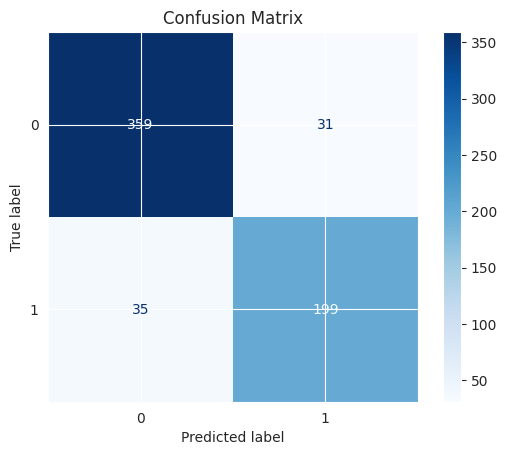

In [43]:
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [44]:
precision_per_class = precision_score(y_test, y_pred_classes, average=None)
print(f'Precision per class: {precision_per_class}')

Precision per class: [0.91116751 0.86521739]


In [45]:
recall_per_class = recall_score(y_test, y_pred_classes, average=None)
print(f'Recall per class: {recall_per_class}')

Recall per class: [0.92051282 0.85042735]


In [48]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')
f1_per_class = f1_score(y_test, y_pred_classes, average=None)

print(f'F1 score per class: {f1_per_class}')

F1 score per class: [0.91581633 0.85775862]
